# Train the persistence model for the clarify persistence forecast integration

Base on Norkyst800 3m temperature data from 2006 - 2022 at grid points closest to fish farm locations

1) derive & save trend ($x_0,y(x_0)$ and $\alpha$)
2) derive & save climatological seasonal cycle (amplitude (3), phase (3), offset)
3) build anomalies (standardized?) and derive lag-correlation, i.e. persistence parameter
4) save persistence parameter as fct of time of year, lead (lag) time

In [1]:
# %load_ext autoreload
# %autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from forecast_clarify.main import *
from forecast_clarify.config import *

### 0. Load base data

In [2]:
ds = xr.open_dataset('/projects/NS9853K/DATA/norkyst800/station_3m/temperature_insitu_3m_norkyst800_barentswatch_closest_20060101-20220920.nc')

In [3]:
filepath = dirs['param_files']

### 1. Estimate trend

In [4]:
# initialize trend class w/ desired polynomial degree:
trnd = trend(degree=1)
# estimate trend:
trnd.fit(ds.squeeze())
# save trend to file:
# trnd.save(os.path.join(filepath,'t3m_trend_nk800_2006-2022_ff.nc'))

### 2. Estimate seasonal cycle of the detrended data

In [5]:
data_dtr = trnd.detrend()

In [6]:
SC = seas_cycle(data_dtr,nharm=3)
SC.fit()
# SC.save(os.path.join(filepath,'t3m_seasonal_cycle_nk800_2006-2022_ff.nc'))
# create anomalies of the training data:
SC.training_anomalies()

In [7]:
# standard deviation seasonal cycle:
SC_std = seas_cycle(SC.anomalies,nharm=3,moment='std')
SC_std.fit()
SC_std.training_anomalies()
# SC_std.save(os.path.join(filepath,'t3m_seasonal_cycle_std_nk800_2006-2022_ff.nc'))

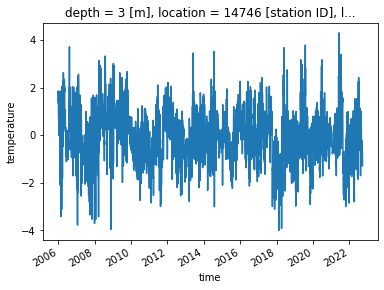

In [8]:
SC_std.anomalies.isel(location=0).temperature.plot()

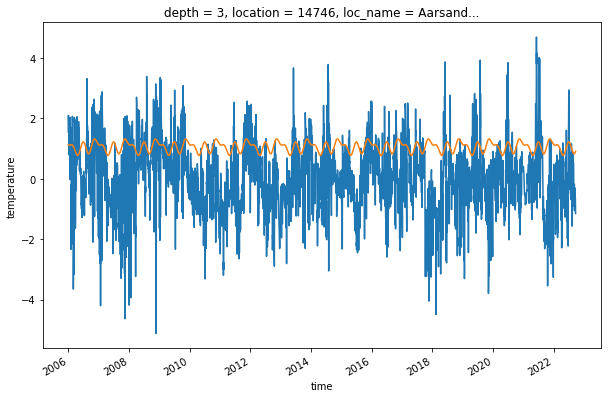

In [9]:
f,ax = plt.subplots(figsize=(10,6))
SC.anomalies.isel(location=0).temperature.plot(ax=ax)
SC_std.sc_exp_doy.isel(location=0).temperature.plot(ax=ax)

# (SC.anomalies.isel(location=0).temperature/SC_std.sc_exp_doy.isel(location=0).temperature).plot(ls='dotted',ax=ax)

### 3. Create anomalies and estimate lagged (running) correlation

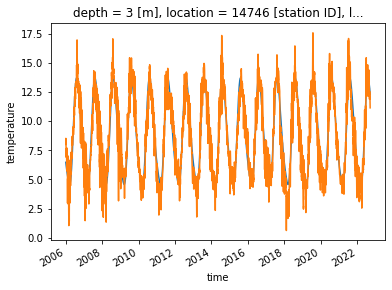

In [10]:
SC.sc_exp_doy.isel(location=0).temperature.plot()
SC.absolute_vals.isel(location=0).temperature.plot()

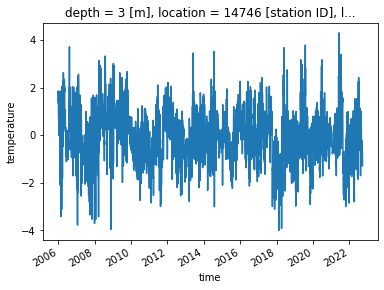

In [11]:
SC_std.anomalies.isel(location=0).temperature.plot()

In [12]:
# process to weekly means:
anoms_weekly = SC_std.anomalies.resample(time='7D').mean('time')

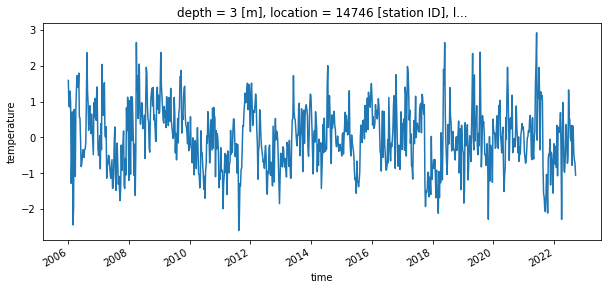

In [13]:
f,ax = plt.subplots(figsize=(10,4))
anoms_weekly.isel(location=0).temperature.plot(ax=ax)
# pers = .6*anoms_weekly.isel(location=0).temperature
# pers = pers.assign_coords(time=anoms_weekly.time + pd.Timedelta('35D'))
# pers.plot(ax=ax)

In [14]:
# simple constant correlation over the entire period (no seasonal dependence)
pers = persistence(lags=5)
pers.fit(anoms_weekly)
# pers.save(os.path.join(filepath,'t3m_persistence_nk800_2006-2022_ff.nc'))

Try a more sophisticated approach with a seasonally varying persistence parameter

In [16]:
WNDW = 61; nharm = 3
pers_seas = persistence_seasonal(lags=6,wndw=WNDW,harmonics=nharm)
pers_seas.fit(anoms_weekly)
# pers_seas.save(os.path.join(filepath,'t3m_persistence_seasonal_cycle_nk800_2006-2022_ff_{0:d}D_wndw_{1:d}}harm.nc'.format(WNDW,nharm)))

In [17]:
# assign a doy variable:
anoms_weekly = anoms_weekly.assign_coords(month_day=get_doy_coord(anoms_weekly,ign_leap=False))

In [19]:
wndw = 61
pad = int(np.ceil((2022 - 2006)/7)) * wndw//2 # make dependent on number of years and window size! 
# pad = 1
anoms_weekly_reorg = xr.DataArray(
    anoms_weekly.temperature.values,
    dims = {
        'month_day' :len(anoms_weekly.time.values),
        'location'  :len(anoms_weekly.location.values),
    },
    coords = {
        'location'  :('location', anoms_weekly.location.values),
        'month_day' :('month_day',anoms_weekly.month_day.values),
        'time'      :('month_day',anoms_weekly.time.values)
    }
).sortby('month_day')
anoms_weekly_reorg = anoms_weekly_reorg.pad(month_day=pad,mode='wrap')
new_month_day = anoms_weekly_reorg.month_day.values
new_month_day[:pad] -= 365; new_month_day[-pad:] += 365

anoms_weekly_reorg2 = xr.DataArray(
    anoms_weekly_reorg.values,
    dims = {
        'time' :len(anoms_weekly_reorg.time.values),
        'location'  :len(anoms_weekly_reorg.location.values),
    },
    coords = {
        'location'  :('location', anoms_weekly_reorg.location.values),
        'month_day' :('time',new_month_day),
        'time'      :('time',anoms_weekly_reorg.time.values)
    }
)

In [20]:
lags = 6
lags_coord = np.arange(1,lags)
corr = []; doy_coo = []
for moda in set(anoms_weekly.month_day.values):
    # if moda > 1:
    #     break
    if moda%10 == 0:
        print(moda)
    doy_coo.append(moda)
    i_sel = np.logical_and(anoms_weekly_reorg2.month_day >= moda-wndw//2,anoms_weekly_reorg2.month_day <= moda+wndw//2)
    corr_lt = []
    for lead_w in range(1,lags):
        start = anoms_weekly_reorg2.time.min() + pd.Timedelta('{:}D'.format(lead_w*7))
        end = anoms_weekly_reorg2.time.max() - pd.Timedelta('{:}D'.format(lead_w*7))
        i_sel_n = i_sel; i_sel_n[i_sel.time > end] = False
        init_slice = anoms_weekly_reorg2.isel(time = i_sel_n)

        # add lead days to init_slice.time and check (one by one) if these dates exist
        coll_lag,coll_ini = [],[]
        for ins in init_slice:
            # print(tt.values)
            lead_date = ins.time + pd.Timedelta('{:}D'.format(lead_w*7))
            lead_doy = lead_date.month_day + lead_w*7
            add_val = anoms_weekly_reorg2.sel(time = lead_date.values)
            if (add_val.month_day == lead_doy.values).dims:
                add_val = add_val.sel(time = add_val.month_day == lead_doy.values)

            # print(lead_doy.values,add_val.month_day.values)
            if add_val.time.values.size > 0:
                coll_lag.append(add_val)
                coll_ini.append(ins)
            # print(anoms_weekly_reorg2.sel(time = lead_date.values))

        init_slice_ = xr.concat(coll_ini,dim='time')
        lag_slice = xr.concat(coll_lag,dim='time').assign_coords(time=init_slice_.time)

        corr_lt.append(xr.corr(init_slice_,lag_slice,dim='time'))
    corr.append(xr.concat(corr_lt,dim=pd.Index(lags_coord,name='lags')))

CORR = xr.concat(corr,dim=pd.Index(doy_coo,name='month_day'))

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360


In [21]:
SC_pers = xr.apply_ufunc(
            seascyc_full,
            CORR.month_day,
            CORR,
            3,
            input_core_dims = [['month_day'],['month_day'],[]],
            output_core_dims = [['month_day'],[],['hrmc'],['hrmc']],
            dask_gufunc_kwargs =  dict(output_sizes = {'hrmc':3}),
            vectorize = True,
            dask = 'parallelized' # does probably not make a difference atm, could try decorating the seascyc functions with numba
        )

CORR_smooth = xr.apply_ufunc(
            construct_clim, # functions
            CORR.month_day.values, SC_pers[1],SC_pers[2],SC_pers[3], # input
            input_core_dims = [['month_day'],[],['hrmc'],['hrmc']],
            output_core_dims = [['month_day'],],
            vectorize = True,
            dask = 'parallelized' # does probably not make a difference atm, could try decorating the seascyc functions with numba
        ).assign_coords(month_day=doy_coo)

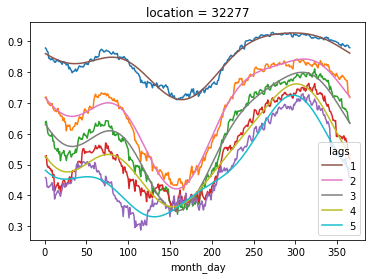

In [22]:
ID = 25
CORR.isel(location=ID).plot(hue='lags')   #.rolling(month_day=30,center=True).mean()
CORR_smooth.isel(location=ID).plot(hue='lags')

In [22]:
CORR

<xarray.DataArray (month_day: 365, lags: 5, location: 1326)>
array([[[0.59813787, 0.50283465, 0.65897931, ..., 0.88460281,
         0.94438955, 0.9130926 ],
        [0.50539493, 0.45282407, 0.50665066, ..., 0.79251001,
         0.8712333 , 0.822082  ],
        [0.47771957, 0.35094542, 0.40635455, ..., 0.72436521,
         0.81468079, 0.77296101],
        [0.32805954, 0.36803466, 0.44421488, ..., 0.63897168,
         0.78273948, 0.76744582],
        [0.27064794, 0.36744827, 0.48934047, ..., 0.63884045,
         0.75021882, 0.72787045]],

       [[0.61181644, 0.49859087, 0.65083001, ..., 0.87877598,
         0.94379661, 0.91721209],
        [0.5012431 , 0.43029197, 0.50158831, ..., 0.79051866,
         0.86997073, 0.83107223],
        [0.47712987, 0.33786916, 0.3930343 , ..., 0.7258343 ,
         0.81456816, 0.78448749],
        [0.35201801, 0.33438827, 0.43497557, ..., 0.63533015,
         0.78288286, 0.77417234],
        [0.26965172, 0.34006281, 0.48648533, ..., 0.6309302 ,
...
         0.94381089, 0.91306865],
        [0.49386493, 0.47559591, 0.49859441, ..., 0.79333717,
         0.87586232, 0.82395963],
        [0.47032837, 0.35324278, 0.40519913, ..., 0.72636732,
         0.81065105, 0.77237076],
        [0.32584602, 0.38931652, 0.43934669, ..., 0.64856789,
         0.77847726, 0.76516286],
        [0.26539919, 0.35885672, 0.49441226, ..., 0.64483271,
         0.75150963, 0.72659109]],

       [[0.60485269, 0.50855782, 0.65766457, ..., 0.88357111,
         0.9440402 , 0.913903  ],
        [0.50382415, 0.46379746, 0.49731701, ..., 0.79192469,
         0.87242469, 0.82636569],
        [0.47040635, 0.37010722, 0.41312967, ..., 0.72334163,
         0.81513217, 0.77547971],
        [0.32246525, 0.40341183, 0.44886187, ..., 0.63549257,
         0.78423143, 0.7706784 ],
        [0.26553457, 0.36312884, 0.50080895, ..., 0.63039616,
         0.7478748 , 0.73088687]]])
Coordinates:
  * location   (location) int64 14746 30196 35297 30977 ... 29417 45032 18595
  * lags       (lags) int64 1 2 3 4 5
  * month_day  (month_day) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

In [23]:
CORR_smooth

<xarray.DataArray (lags: 5, location: 1326, month_day: 365)>
array([[[0.61706576, 0.61593892, 0.61477808, ..., 0.62023907,
         0.61921604, 0.61815822],
        [0.53561267, 0.53401725, 0.5325445 , ..., 0.54109998,
         0.53915768, 0.53732734],
        [0.66941766, 0.67078927, 0.67226335, ..., 0.66594296,
         0.66699214, 0.66815113],
        ...,
        [0.87841961, 0.87705838, 0.87567837, ..., 0.88235976,
         0.88107334, 0.87975895],
        [0.92774366, 0.92648379, 0.92521865, ..., 0.9314754 ,
         0.9302411 , 0.92899665],
        [0.90963405, 0.91044505, 0.91119947, ..., 0.90684959,
         0.90783736, 0.90876519]],

       [[0.52243453, 0.52139249, 0.52027078, ..., 0.52510601,
         0.52428881, 0.52339917],
        [0.45034392, 0.45003013, 0.44982075, ..., 0.4519154 ,
         0.45128633, 0.45076255],
        [0.5207436 , 0.52171943, 0.52279716, ..., 0.51845298,
         0.51910802, 0.51987231],
...
        [0.63474765, 0.63407693, 0.63355261, ..., 0.63763981,
         0.63652945, 0.63556519],
        [0.74139384, 0.74107074, 0.74082633, ..., 0.74286055,
         0.7422866 , 0.74179835],
        [0.73984281, 0.74009196, 0.74029916, ..., 0.73880701,
         0.73920413, 0.73954811]],

       [[0.28731189, 0.28424773, 0.28121547, ..., 0.29668312,
         0.29353101, 0.29040676],
        [0.32723503, 0.32768268, 0.32824309, ..., 0.32658466,
         0.32668457, 0.32690182],
        [0.47428715, 0.47347522, 0.4727478 , ..., 0.47721802,
         0.47615999, 0.47518251],
        ...,
        [0.6386599 , 0.63921784, 0.63988247, ..., 0.63766019,
         0.63787817, 0.63821229],
        [0.7097055 , 0.71005854, 0.71047564, ..., 0.70908404,
         0.70921333, 0.70942205],
        [0.71631966, 0.71564279, 0.71487527, ..., 0.71775419,
         0.71738065, 0.7169007 ]]])
Coordinates:
  * location   (location) int64 14746 30196 35297 30977 ... 29417 45032 18595
  * lags       (lags) int64 1 2 3 4 5
  * month_day  (month_day) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

In [221]:
CORR.to_netcdf(os.path.join(dirs['param_files'],'t3m_persistence_seasonal_cycle_{0:d}D_wndw.nc'.format(wndw)))
CORR_smooth.to_netcdf(os.path.join(dirs['param_files'],'t3m_persistence_seasonal_cycle_{0:d}D_wndw_3hrm.nc'.format(wndw)))